TODO
1. create test images with simple shapes and colors
2. degug pixelate
3. optimize pixelate

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot  as plt
from mpl_toolkits.mplot3d import Axes3D

In [29]:
# returns the Euclidean distance between two rgb colors
def color_distance(color0, color1):
  r0, g0, b0 = color0
  r1, g1, b1 = color1
  r_delta_sqrd = (r1 - r0) ** 2
  g_delta_sqrd = (g1 - g0) ** 2
  b_delta_sqrd = (b1 - b0) ** 2
  euclidean_distance = np.sqrt(r_delta_sqrd + g_delta_sqrd + b_delta_sqrd)
  return euclidean_distance

In [30]:
def group_pixels(image, threshold):
  # initialize locals
  groups = []
  rows, cols = image.shape[:2]

  # used to store a map of the groups
  group_mask = np.full((rows, cols), -1, dtype=np.float32)

  # Pad image to handle edges
  padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0).astype(np.float32)

  # Apply kernel
  for i in range(rows):
    for j in range(cols):
      region = padded_image[i:i+3, j:j+3]
      group_candidates = []

      # target is the center pixel in the kernel
      target = region[1, 1]

      # traverse the kernel region and compare neighbours to target
      for x in range(3):
        for y in range(3):

          # only check neighbours (not target itself)
          if (x != y != 1):

            # if the Euc. distance between target and neighbour < threshold
            # add the (distance, neighbour coords) to list of candidates for
            # which group to add the target to
            #
            # NOTE: the neighbour coords will be the current target coords
            # shifted by the current pixel location in the kernel
            dist = color_distance(target[1:4], region[y, x][1:4])
            if (dist < threshold):

              # define kernel offsets for getting location of the current 
              # candidate w/ respect to the image
              x_kernel_offset = -1 if x == 0 else 1
              y_kernel_offset = -1 if y == 0 else 1

              # add the candidate distance and image-relative coords
              group_candidates.append((dist, (x + x_kernel_offset, y + y_kernel_offset)))

      # no candidates found -> assign to new group
      if (len(group_candidates) == 0):
        groups.append(int(len(groups)))
        group_mask[i, j] = groups[-1]

      # candidates found -> assign to best (min dist value) neighbour
      else:
        best_candidate = sorted(group_candidates, key=lambda p: p[0])[0]
        bestX, bestY = best_candidate[1]

        # best candidate not in group -> create new group and add target / best to group
        if (group_mask[bestY, bestX] == -1):
          groups.append(int(len(groups)))
          group_mask[i, j] = group_mask[bestY, bestX] = groups[-1]

        # best candidate in group -> add target to best's group
        else:
          group_mask[i, j] = group_mask[bestY, bestX]

  return group_mask, groups

In [31]:
def average_groups(groups, group_mask, image):
  for group in groups:
    group_region = image[group_mask == group]
    group_avg = np.mean(group_region, axis=0)
    image[group_mask == group] = group_avg

  return image

In [32]:
def plot_image(image, title):
    """
    Plots a 3D surface plot of a given 2D image (grayscale or intensity map).
    :param image: 2D NumPy array representing pixel values
    :param title: Title of the plot
    """
    x = np.arange(image.shape[1])  # X coordinates
    y = np.arange(image.shape[0])  # Y coordinates
    X, Y = np.meshgrid(x, y)  # Create mesh grid
    Z = image  # Pixel values as heights
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Pixel Intensity')
    
    plt.show()

In [ ]:
def color_segment(image, threshold=0):
  # group all pixels with color distance < threshold as one
  group_mask, groups = group_pixels(image, threshold)
  plot_image(group_mask, 'group mask')

  # for each group, assign color as group average
  #test = average_groups(groups, group_mask, image)

  # return image
  return test

### Test

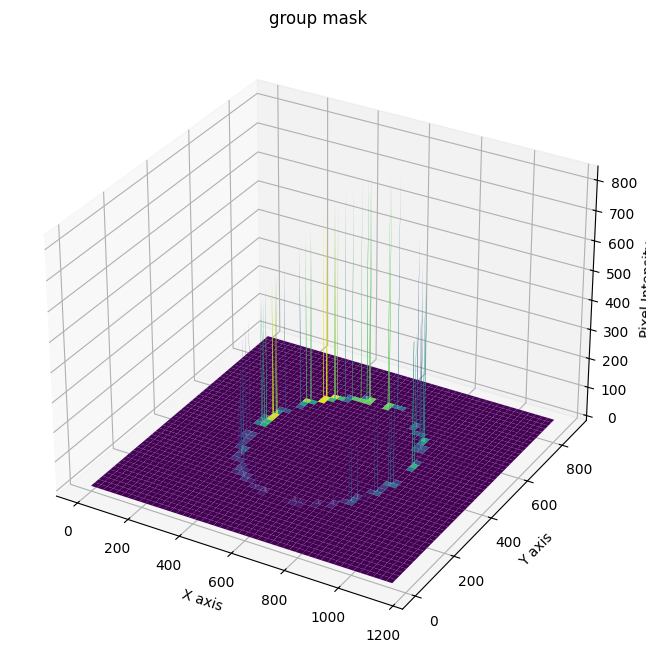

In [36]:
image = cv2.imread("Test Images\\black_circle.jpg", cv2.IMREAD_COLOR_RGB)
test = color_segment(image, threshold=5)